In [1]:
import pandas as pd
from keras.layers import Input, Dense,Dropout
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.layers import Input, Dense,Dropout
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split

from keras.layers import *

Using TensorFlow backend.


# Loading Dataset

In [2]:

data=pd.read_csv('../competitions/chicago_taxi_trips_2016_01.csv')

data=data[['taxi_id','trip_start_timestamp','trip_end_timestamp','trip_seconds','trip_miles','pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude']]


# Preprocessing

In [3]:

data=data.dropna()
data=data.reset_index(drop=True)
data['trip_seconds']=data['trip_seconds']/60.0
data=data[data['trip_seconds']>2.0]
data=data.reset_index(drop=True)



In [4]:
data.iloc[1030281]

taxi_id                              1742
trip_start_timestamp    2016-1-2 15:15:00
trip_end_timestamp      2016-1-2 15:15:00
trip_seconds                            4
trip_miles                            0.6
pickup_latitude                       167
pickup_longitude                      754
dropoff_latitude                      744
dropoff_longitude                     605
Name: 1030281, dtype: object

In [5]:

embed_data=data[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']]
embed_data['pickup_latitude'] =(embed_data['pickup_latitude']-min(embed_data.pickup_latitude))/(max(embed_data.pickup_latitude)-min(embed_data.pickup_latitude))
embed_data['pickup_longitude'] =(embed_data['pickup_longitude']-min(embed_data.pickup_longitude))/(max(embed_data.pickup_longitude)-min(embed_data.pickup_longitude))
embed_data['dropoff_latitude'] =(embed_data['dropoff_latitude']-min(embed_data.dropoff_latitude))/(max(embed_data.dropoff_latitude)-min(embed_data.dropoff_latitude))
embed_data['dropoff_longitude'] =(embed_data['dropoff_longitude']-min(embed_data.dropoff_longitude))/(max(embed_data.dropoff_longitude)-min(embed_data.dropoff_longitude))



/home/user/.conda/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/user/.conda/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/user/.conda/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

# Entity Embeddings

In [28]:

from keras.layers.embeddings import Embedding
from keras.models import Model,Sequential
from keras.layers import *
model_in=[]
model_op=[]
l=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
for categorical_var in l:
    print(categorical_var)
    
    no_of_unique_cat  = data[categorical_var].nunique()
    embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
    embedding_size = int(embedding_size)
    vocab  = no_of_unique_cat+1
    input_layer = Input(shape=(1,))
    model=Embedding(vocab ,embedding_size )(input_layer)
    model=Reshape(target_shape=(embedding_size,))(model)
    model=Dropout(0.5)(model)
    #model1 = Model(input_layer,model)
    model_in.append(input_layer)
    model_op.append(model)


pickup_latitude
pickup_longitude
dropoff_latitude
dropoff_longitude


In [7]:

data['start_Date'] = pd.to_datetime(data['trip_start_timestamp'])
data['end_Date'] = pd.to_datetime(data['trip_end_timestamp'])
data=data.drop(columns=['trip_start_timestamp'])
data=data.drop(columns=['trip_end_timestamp'])
data['start_year'] = data['start_Date'].dt.year
data['start_month'] = data['start_Date'].dt.month
data['start_day'] = data['start_Date'].dt.day
data['start_hour'] = data['start_Date'].dt.hour
data['end_year'] = data['end_Date'].dt.year
data['end_month'] = data['end_Date'].dt.month
data['end_day'] = data['end_Date'].dt.day
data['end_hour'] = data['end_Date'].dt.hour



In [8]:
import numpy as np

data=data.drop(columns=['start_Date'])
data=data.drop(columns=['end_Date'])
X=pd.DataFrame()
X['distance'] =(data['trip_miles']-min(data.trip_miles))/(max(data.trip_miles)-min(data.trip_miles))
X['start_hour'] =data['start_hour']/max(data.start_hour)
X['start_day'] =data['start_day']/max(data.start_day)
X['end_hour'] =data['end_hour']/max(data.end_hour)
X['end_day'] =data['end_day']/max(data.end_day)

In [11]:
data.trip_seconds.max()

1439.0

# train test split

In [14]:


Y=pd.DataFrame()

Y=(data['trip_seconds']-min(data.trip_seconds))/(max(data.trip_seconds)-min(data.trip_seconds))

Y=np.array(Y)


X_train, X_test = X[0:1030281], X[1030281:]
y_train, y_test = Y[0:1030281], Y[1030281:]
embed_train,embed_test=embed_data[0:1030281],embed_data[1030281:]

In [15]:
Y[1030281]*(max(data.trip_seconds)-min(data.trip_seconds))+min(data.trip_seconds)

4.0

In [16]:
x=pd.concat([embed_train,X_train],axis=1)
x_test=pd.concat([embed_test,X_test],axis=1)

In [17]:
X.shape

(1287852, 5)

# Model

In [29]:
## input layer 
input_layer = Input(shape=(X.shape[1],))
# embed_input = Input(shape=(embed_train.shape[1],))

## encoding part
encoded = Dense(100, activation='relu')(input_layer)
dropout=Dropout(0.2)(encoded)
## decoding part

from keras.layers import *
emb_merge=concatenate(model_op)


decoded = Dense(50, activation='relu')(emb_merge)
emb_merge1=concatenate([dropout,decoded])
dropout=Dropout(0.2)(emb_merge1)
decoded = Dense(20, activation='relu')(dropout)
dropout1=Dropout(0.5)(decoded)
last=Dense(10, activation='relu')(dropout)

## output layer
output_layer = Dense(1,activation='sigmoid')(decoded)

In [30]:
model_in.append(input_layer)
autoencoder = Model(model_in, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

In [31]:
autoencoder.load_weights('best1')

In [32]:
predictions=autoencoder.predict([x_test.pickup_latitude.values,x_test.pickup_longitude.values,x_test.dropoff_latitude.values,x_test.dropoff_longitude.values,X_test])

In [33]:
def mapping(l):
    return l*((max(data.trip_seconds)-min(data.trip_seconds)))+min(data.trip_seconds)

# Inference

In [34]:
y_pred=predictions*((max(data.trip_seconds)-min(data.trip_seconds)))+min(data.trip_seconds)
# for i in predictions:
#     y_pred.append(mapping(i))

In [35]:
import itertools
y_pred = list(itertools.chain(*y_pred))

In [36]:
y_true=y_test*((max(data.trip_seconds)-min(data.trip_seconds)))+min(data.trip_seconds)

In [37]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true, y_pred)

54.25524651369126

In [38]:
import matplotlib.pyplot as plt

In [39]:
y_true

array([ 4.,  8.,  9., ..., 23., 16.,  6.])

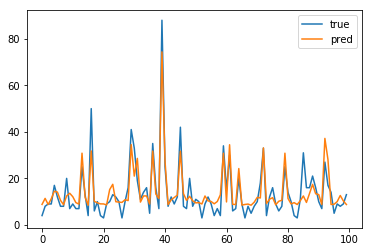

In [40]:
plt.plot(list(range(100)),y_true[0:100],label='true')
plt.plot(list(range(100)),y_pred[0:100],label='pred')
plt.legend()

In [41]:
x_test.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance,start_hour,start_day,end_hour,end_day
1030281,0.213010,0.960459,0.948980,0.770408,0.000200,0.652174,0.064516,0.652174,0.064516
1030282,0.961735,0.521684,0.788265,0.517857,0.000000,0.608696,1.000000,0.652174,1.000000
1030283,0.536990,0.056122,0.452806,0.423469,0.000367,0.000000,0.516129,0.000000,0.516129
1030284,0.877551,0.261480,0.928571,0.352041,0.000000,0.478261,0.096774,0.521739,0.096774
1030285,0.764031,0.440051,0.841837,0.151786,0.002100,0.782609,0.193548,0.782609,0.193548


In [44]:
y_test[0]

0.0006963788300835655

In [45]:
test=pd.DataFrame([[0.213010,0.960459,0.948980,0.770408]],columns=list(x_test.columns)[0:4])

In [46]:
test1=pd.DataFrame([[0.000200,0.652174,0.064516,0.652174,0.064516]],columns=list(x_test.columns)[4:])

In [47]:
predictions1=autoencoder.predict([[0.213010],[0.960459],[0.948980],[0.948980],test1])

In [48]:
test1

,distance,start_hour,start_day,end_hour,end_day
0,0.0002,0.652174,0.064516,0.652174,0.064516


In [49]:
preds=[]
for i in range(5):
    preds.append(autoencoder.predict([[0.213010],[0.960459],[0.948980],[0.948980],test1])[0][0])
    test1.iloc[0]['start_hour']=((test1.iloc[0]['start_hour']*24)+1)/24

In [123]:
np.set_printoptions(suppress=False)

In [50]:
pred=np.array(preds)*((max(data.trip_seconds)-min(data.trip_seconds)))+min(data.trip_seconds)

In [51]:
pred

array([   8.8053   ,    7.5524483,  150.99275  , 1017.8422   ,
        957.6284   ], dtype=float32)

In [52]:
for i in rangelen(pred)):
    print("time in "+str(i)+" hour is"+pred[i])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [118]:
preds

[2.7940786e-18, 9.357278e-19, 3.133662e-19, 1.0490929e-19, 3.512185e-20]